# NOTEBOOK SETUP

## IMPORT REQUIRED LIBRARIES

In [35]:
import os
os.environ['USE_PYGEOS'] = '0'
import sys
sys.path.append(os.path.realpath('..'))
from pathlib import Path

import sys
import importlib

import pandas as pd
import numpy as np
import itertools

import geopandas as gpd
import fiona




import pyrosm

import osmnx as ox
import networkx as nx
import pandana as pdna

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import urllib.request
import zipfile

import matplotlib
import matplotlib.pyplot as plt

import time






In [2]:
os.getcwd()

'c:\\Users\\pbatista\\OneDrive - inegi.up.pt\\APP_PROJECTS\\GeoNetworkAnalysis_PT\\notebooks'

# FOLDER PATHS

In [3]:
# path_PC = "C:/Users/pauloricardolb/"
path_PC = r'C:\Users\pbatista'


project_path = r'.'

path_inputs = r'..\data\data_inputs'



# GET OFFICIAL ADMIN GEODATA (for PT)

In [4]:
# Data source: "Direção-Geral do Território (DGT) - Portugal"
# More detailed data on https://www.dgterritorio.gov.pt/cartografia/cartografia-tematica/caop
# Data is available in the "GeoPackage" format "gpkg", which is a standard open format for spatial data storage and exchange

url = 'https://geo2.dgterritorio.gov.pt/caop/CAOP_Continente_2023-gpkg.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.extractall( os.path.join(os.getcwd(), path_inputs) )
zip_file_object.close()


In [5]:
# See which layers are available in the (geo)database file
# It has layers for the mainland Portugal at different administrative levels (parishes, municipalities, NUTSIII/Intermunicipality Regions, etc.)
# Mainly of the layers are polygons, but there are also lines versions of the parishes boundaries

print(fiona.listlayers(path_inputs + r'\Continente_CAOP2023.gpkg'))

['Cont_AAD_CAOP2023', 'Cont_Dist_CAOP2023', 'Cont_Freg_CAOP2023', 'Cont_Mun_CAOP2023', 'Cont_NUTSI_CAOP2023', 'Cont_NUTSII_CAOP2023', 'Cont_NUTSIII_CAOP2023', 'Cont_Troco_CAOP2023', 'layer_styles']


In [6]:
# The layeres can be read as GeoDataFrames and manipulated accordingly
# For example, the layer "Cont_AAD_CAOP2023" contains the boundaries of the parishes in mainland Portugal
# The following code reads the layer for Portugal mainlan as a unique polygons (NUTS I level) and plots it


gdf_Cont_NUTSI_CAOP2023 = gpd.read_file(path_inputs + r'\Continente_CAOP2023.gpkg', layer='Cont_NUTSI_CAOP2023')
gdf_Cont_NUTSI_CAOP2023.head(3)





,NUTI_COD,NUTI_DSG,N_Freguesi,Area_ha,geometry
0,1,Continente,2882,8910214.28,"MULTIPOLYGON (((-69674.530 -294276.294, -69681..."


<Axes: >

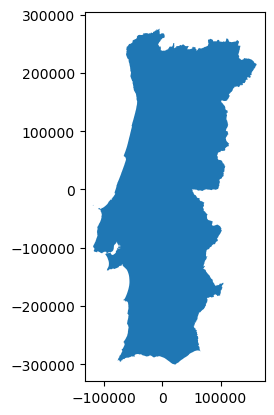

In [7]:
gdf_Cont_NUTSI_CAOP2023.plot()

In [8]:
# Note that the geo data is in the "EPSG:3763" coordinate system, which is the official coordinate system for Portugal and it is a projected coordinate system
# To use with international data, it is better to use the "EPSG:4326" coordinate system, which is the standard coordinate system for GPS and other global georeferencing systems
print("ORIGINAL COORDINATE SYSTEM:") 
print(gdf_Cont_NUTSI_CAOP2023.crs)

# The following code reprojects the data to the "EPSG:4326" coordinate system
gdf_Cont_NUTSI_CAOP2023_wgs84 = gdf_Cont_NUTSI_CAOP2023.to_crs(epsg=4326)

print("NEW - WGS84 - COORDINATE SYSTEM: ")
print(gdf_Cont_NUTSI_CAOP2023_wgs84.crs)

ORIGINAL COORDINATE SYSTEM:
EPSG:3763
NEW - WGS84 - COORDINATE SYSTEM: 
EPSG:4326


# GET OSM (OPEN STREET MAPS) DATA

Sugested data source: https://download.geofabrik.de/

In [9]:
def download_osm_file(url, save_to, filename) :
    # url     - url of downloadable file
    # save_to - directory to save the file to
    
    from os import chdir, getcwd
    from requests import get
    
    print("downloading from url:", url)       
    req = get(url)
    chdir(save_to)
    
    print("writing", filename)
    with open(filename, 'wb') as file: 
        for chunk in req.iter_content(chunk_size=(8192)):
            if chunk:
                file.write(chunk)
    file.close()
    print(filename, "has been downloaded to", getcwd())



In [10]:
# WARNING: This file is about 1.5 GB in size it takes long time to download

# url = 'http://download.geofabrik.de/europe/portugal-latest.osm.pbf'
# save_to = os.path.join(os.getcwd(), path_inputs)
# filename = 'portugal-latest.osm.pbf'

# download_osm_file(url, save_to, filename)

# GET NETWORK from OSM Data


## All country
WARMING: This process can take a long time and a lot of memory. It is recommended to use a smaller area to test the process.

In [11]:
# osm = pyrosm.OSM(save_to + '\portugal-latest.osm.pbf') 
# portugal_network_all = osm.get_network(network_type = 'all')

## Selected area based on shapefile 
(Example: Porto municipality)

In [23]:
# Get Porto municipality polygon boyndary from official administrative data

gdf_Cont_Mun_CAOP2023 = gpd.read_file(path_inputs + r'\Continente_CAOP2023.gpkg', layer='Cont_Mun_CAOP2023')
gdf_Cont_Mun_CAOP2023.head(3)

,DICO,Municipio,Distrito,N_Freguesi,NUTSIII,NUTSII,NUTSI,Alt_Max,Alt_Min,Area_ha,Perim_km,geometry
0,0101,Águeda,Aveiro,11,Região de Aveiro,Centro,Continente,762,4,33527.44,105,"MULTIPOLYGON (((-20560.758 113803.912, -20550...."
1,0102,Albergaria-a-Velha,Aveiro,6,Região de Aveiro,Centro,Continente,425,0,15882.50,82,"MULTIPOLYGON (((-26966.491 123573.381, -26964...."
2,0103,Anadia,Aveiro,10,Região de Aveiro,Centro,Continente,525,13,21663.48,75,"MULTIPOLYGON (((-17449.514 93729.645, -17450.2..."


In [24]:
gdf_Cont_Mun_CAOP2023 = gdf_Cont_Mun_CAOP2023.dissolve(by=['DICO', 'Municipio'])
gdf_Cont_Mun_CAOP2023.reset_index(inplace=True)
gdf_Cont_Mun_CAOP2023.head(3)

,DICO,Municipio,geometry,Distrito,N_Freguesi,NUTSIII,NUTSII,NUTSI,Alt_Max,Alt_Min,Area_ha,Perim_km
0,0101,Águeda,"POLYGON ((-20560.758 113803.912, -20550.798 11...",Aveiro,11,Região de Aveiro,Centro,Continente,762,4,33527.44,105
1,0102,Albergaria-a-Velha,"POLYGON ((-26966.491 123573.381, -26964.759 12...",Aveiro,6,Região de Aveiro,Centro,Continente,425,0,15882.50,82
2,0103,Anadia,"POLYGON ((-17449.514 93729.645, -17450.254 937...",Aveiro,10,Região de Aveiro,Centro,Continente,525,13,21663.48,75


In [25]:
gdf_Cont_Mun_Porto_CAOP2023 = gdf_Cont_Mun_CAOP2023[gdf_Cont_Mun_CAOP2023['Municipio'] == 'Porto']
gdf_Cont_Mun_Porto_CAOP2023.head(3)

,DICO,Municipio,geometry,Distrito,N_Freguesi,NUTSIII,NUTSII,NUTSI,Alt_Max,Alt_Min,Area_ha,Perim_km
189,1312,Porto,"POLYGON ((-39467.364 168625.134, -39370.344 16...",Porto,7,Área Metropolitana do Porto,Norte,Continente,157,0,4142.02,36


<Axes: >

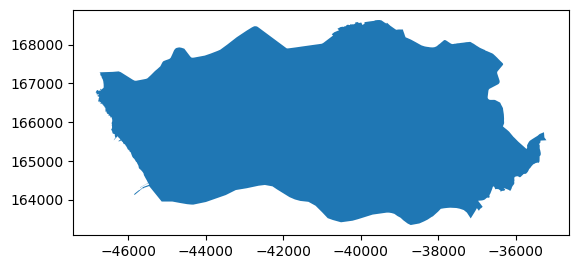

In [26]:
gdf_Cont_Mun_Porto_CAOP2023.plot()

<Axes: >

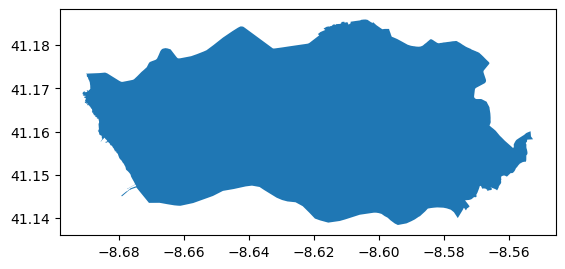

In [27]:
gdf_Cont_Mun_Porto_CAOP2023_WGS84 = gdf_Cont_Mun_Porto_CAOP2023.to_crs(epsg=4326)
gdf_Cont_Mun_Porto_CAOP2023_WGS84.plot()

In [28]:
gdf_Cont_Mun_Porto_CAOP2023_WGS84.geometry

189    POLYGON ((-8.60353 41.18586, -8.60237 41.18526...
Name: geometry, dtype: geometry

In [29]:
gdf_Cont_Mun_Porto_CAOP2023_WGS84.geometry.type 

189    Polygon
dtype: object

In [84]:
porto_network_all = ox.graph_from_polygon(gdf_Cont_Mun_Porto_CAOP2023_WGS84.iloc[0]['geometry'], network_type='drive', simplify=True, retain_all=True, truncate_by_edge=True)
porto_network_all_nodes, porto_network_all_edges = ox.graph_to_gdfs(porto_network_all, nodes=True, edges=True)

# GET OD MATRIX DISTANCES OPTION 1 - OSMNX

In [96]:
# Create fake data as our origin and destination points

from shapely.geometry import Point, Polygon

def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y


x_o,y_o = Random_Points_in_Bounds(gdf_Cont_Mun_Porto_CAOP2023_WGS84.iloc[0]['geometry'], 10)
df_origin = pd.DataFrame()
df_origin['points'] = list(zip(x_o,y_o))
df_origin['points'] = df_origin['points'].apply(Point)
df_origin.reset_index(inplace=True)
df_origin.rename(columns={'index' : 'origin_id'}, inplace=True)
gdf_origin = gpd.GeoDataFrame(df_origin, geometry='points')
# gdf_origin.rename(columns={'points' : 'geometry'}, inplace=True)

x_d,y_d = Random_Points_in_Bounds(gdf_Cont_Mun_Porto_CAOP2023_WGS84.iloc[0]['geometry'], 10)
df_destinations = pd.DataFrame()
df_destinations['points'] = list(zip(x_d,y_d))
df_destinations['points'] = df_destinations['points'].apply(Point)
df_destinations.reset_index(inplace=True)
df_destinations.rename(columns={'index' : 'destination_id'}, inplace=True)
gdf_destinations = gpd.GeoDataFrame(df_destinations, geometry='points')


In [100]:
# IMPORTANT NOTE
# When use the OSMNx library routing capabilities, it is necessary to convert the origin and destination points to the nearest nodes in the network
# thus, the path between the real location and the nearest node is not considered in the routing distance (or time) calculation!
# in fact, routing is only possible between nodes in the network, not directly between any point in the map
# this piece of code will find the nearest node on the network for each origin and destination real point

def nearest_node(a,b):
    nearest_node, dist=ox.nearest_nodes(porto_network_all, a,b, return_dist=True)  
    return nearest_node

gdf_origin['NX_node'] = np.vectorize(nearest_node)(gdf_origin.points.x, gdf_origin.points.y)
gdf_destinations['NX_node'] = np.vectorize(nearest_node)(gdf_destinations.points.x, gdf_destinations.points.y)


In [113]:
# Create all combinations of origins and destinations
od = list(itertools.product(gdf_origin.index, gdf_destinations.index))

# Create a DataFrame with these pairs
df_od = pd.DataFrame(od, columns=['origin_id', 'destination_id'])

# Merge the origin and destination GeoDataFrames to get geometry for each pair
df_od = df_od.merge(gdf_origin, left_on='origin_id', right_on='origin_id', suffixes=('_origin', '_destination'))
df_od = df_od.merge(gdf_destinations, left_on='destination_id', right_on='destination_id',  suffixes=('_origin', '_destination'))


In [114]:
origin_nodelist = list(gdf_origin['NX_node'].unique())
origin_nodelist_df = porto_network_all_nodes[porto_network_all_nodes.index.isin(origin_nodelist)]
origin_nodelist_df.reset_index(inplace=True)
origin_nodelist_df.drop(columns=['street_count', 'highway', 'ref'], inplace=True)
origin_nodelist_df.rename(columns={'osmid' : 'osmid_origin', 
                                   'y' : 'y_node_origin',
                                   'x' : 'x_node_origin',
                                    'geometry' :  'geometry_node_origin' }, inplace=True)

df_od = df_od.merge(origin_nodelist_df, left_on='NX_node_origin', right_on='osmid_origin')

destinations_nodelist = list(gdf_destinations['NX_node'].unique())
destinations_nodelist_df = porto_network_all_nodes[porto_network_all_nodes.index.isin(destinations_nodelist)]
destinations_nodelist_df.reset_index(inplace=True)
destinations_nodelist_df.drop(columns=['street_count', 'highway', 'ref'], inplace=True)
destinations_nodelist_df.rename(columns={'osmid' : 'osmid_destination', 
                                   'y' : 'y_node_destination',
                                   'x' : 'x_node_destination',
                                    'geometry' :  'geometry_node_destination' }, inplace=True)

df_od = df_od.merge(destinations_nodelist_df, left_on='NX_node_destination', right_on='osmid_destination')

df_od.head(15)



C:\Users\pbatista\AppData\Local\Temp\ipykernel_12988\4020017502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_nodelist_df.drop(columns=['street_count', 'highway', 'ref'], inplace=True)
C:\Users\pbatista\AppData\Local\Temp\ipykernel_12988\4020017502.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origin_nodelist_df.rename(columns={'osmid' : 'osmid_origin',
C:\Users\pbatista\AppData\Local\Temp\ipykernel_12988\4020017502.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,origin_id,destination_id,points_origin,NX_node_origin,points_destination,NX_node_destination,osmid_origin,y_node_origin,x_node_origin,geometry_node_origin,osmid_destination,y_node_destination,x_node_destination,geometry_node_destination
0,0,0,POINT (-8.56418 41.14659),2583505067,POINT (-8.59828 41.17033),4573702097,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),4573702097,41.170446,-8.598315,POINT (-8.59831 41.17045)
1,0,1,POINT (-8.56418 41.14659),2583505067,POINT (-8.60814 41.17175),504782514,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),504782514,41.172216,-8.607801,POINT (-8.60780 41.17222)
2,0,2,POINT (-8.56418 41.14659),2583505067,POINT (-8.57371 41.17798),1731170737,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),1731170737,41.177672,-8.573596,POINT (-8.57360 41.17767)
3,0,3,POINT (-8.56418 41.14659),2583505067,POINT (-8.67705 41.17285),301110290,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),301110290,41.172927,-8.674313,POINT (-8.67431 41.17293)
4,0,4,POINT (-8.56418 41.14659),2583505067,POINT (-8.64504 41.16249),4505293700,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),4505293700,41.162147,-8.645205,POINT (-8.64521 41.16215)
5,0,5,POINT (-8.56418 41.14659),2583505067,POINT (-8.62031 41.15965),428217533,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),428217533,41.159241,-8.620276,POINT (-8.62028 41.15924)
6,0,6,POINT (-8.56418 41.14659),2583505067,POINT (-8.58035 41.16677),3570147062,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),3570147062,41.166880,-8.581236,POINT (-8.58124 41.16688)
7,0,7,POINT (-8.56418 41.14659),2583505067,POINT (-8.68312 41.14864),4722390314,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),4722390314,41.151226,-8.677499,POINT (-8.67750 41.15123)
8,0,8,POINT (-8.56418 41.14659),2583505067,POINT (-8.63512 41.17604),3241070503,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),3241070503,41.176168,-8.634951,POINT (-8.63495 41.17617)
9,0,9,POINT (-8.56418 41.14659),2583505067,POINT (-8.68331 41.14538),1353859183,2583505067,41.146523,-8.566702,POINT (-8.56670 41.14652),1353859183,41.148960,-8.675540,POINT (-8.67554 41.14896)


## Apply the short path algorithm from osmnx

In [115]:
def path_length(row):
    return nx.shortest_path_length(porto_network_all, row['NX_node_origin'], row['NX_node_destination'], weight='length')

# apply the function to our OD data
%timeit df_od['path_length'] = df_od.apply(path_length, axis=1)

862 ms ± 22.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# GET OD MATRIX DISTANCES OPTION 2 - PANDANA
» Coming soon

# GET OD MATRIX TRAVEL TIME OPTION 1 - OSMNX
» Coming soon 

NOTE:
-» It requires: 
a) add the travel times using the function add_edge_speeds() to impute the speed in km/h as mean or max speed values of roads, per highway type (note that legal max speed limit cannot be a good data to estimate travel times, because it is not the same as the real speed of the road)
b) calculate the travel times using the function add_edge_travel_time() which combines the edge speeds and distances to calculate the travel times